In [1]:
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from pydantic import BaseModel, Field
import requests, json
from typing_extensions import TypedDict
from typing import Annotated, Literal
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_tavily import TavilySearch
from langchain.schema import HumanMessage, AIMessage, BaseMessage
from langchain.tools import tool
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
import os

Loading API Keys from .env and initialising Chat Model

In [2]:
load_dotenv()
llm = init_chat_model("google_genai:gemini-2.0-flash")

Defining a Class for messages structure that contains the content and message type ("general", "weather", "calculator","fashion")

In [3]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    message_type: str | None


Assigning "message_type" as one of the four options

In [4]:
class MessageClassifier(BaseModel):
    message_type: Literal["calculator", "weather", "fashion", "general"] = Field(
        ...,
        description="Classify if the message asks for a general query, calculation of numbers, weather of a place, fashion trends of a location, or is a general greeting/question not requiring a specific tool."
    )


A function to classify the incoming message as calculator, weather,fashion or general based on the prompt provided

In [5]:
def classify_message(state: State):
    last_message = state["messages"][-1]
    classifier_llm = llm.with_structured_output(MessageClassifier)

    result = classifier_llm.invoke([
        {"role": "system", "content": """Classify the message as either:
        - 'calculator' : if the message contains performing arithemetic operations on a set of numbers
        - 'weather' : if the message asks for weather or temperature of a place
        - 'fashion' : if the message asks for the fashion trends of a place
        - 'general' : if the message is a greeting (e.g., "Hi", "Hello"), a simple chat, or a question that does not require any specific tool usage (e.g., "What is your name?", "How are you?").
"""},
        {"role": "user", "content": last_message.content}
    ])
    return {"message_type": result.message_type, "messages": []}



The output from classify_message is passed on to the router that sets the "next" property for a message to route it to the specific agent

In [6]:
def router(state: State):
    message_type = state.get("message_type", "general")
    return {"next": message_type}

Defining tool for the calculator agent that takes a string as input and returns the evaluated expression in float datatype by using the eval function

In [7]:
@tool
def arithmetic_bodmas(exp: str) -> float:
    """
    Evaluating an arithmetic expression using bodmas consisting of '+','-','*','/','%','(',')','[',']','{','}','^'.
    Replace ^ with **.
    a%b represents the remainder when a is divided by b, the answer is always an integer.
    """
    try:
        exp = exp.replace('^', '**')
        return eval(exp)
    except Exception as e:
        return f"Error evaluating expression: {e}"

Defining tool for weather agent that connects to an API and fetches the weather of a particular city, returns details of temperature, pressure and humidity

In [8]:
@tool
def weather_tool(city: str) -> str:
    """
    Taking city name or location as string input and fetching the temperature, pressure, humidity and weather description.
    """
    weather_api_key = os.environ.get("WEATHER_API_KEY")
    if not weather_api_key:
        return "Weather API key not found. Please set the 'WEATHER_API_KEY' environment variable."

    base_url = "http://api.openweathermap.org/data/2.5/weather?"
    complete_url = base_url + "appid=" + weather_api_key + "&q=" + city
    
    try:
        response = requests.get(complete_url)
        x = response.json()

        if x["cod"] != "404":
            y = x["main"]
            current_temperature = y["temp"]-273.15
            current_pressure = y["pressure"]
            current_humidity = y["humidity"]
            z = x["weather"]
            weather_description = z[0]["description"]

            return (f"Temperature (in Celsius unit) = {current_temperature}\n"
                    f"Atmospheric pressure (in hPa unit) = {current_pressure}\n"
                    f"Humidity (in percentage) = {current_humidity}\n"
                    f"Description = {weather_description}")
        else:
            return f"City '{city}' not found or weather data unavailable."
    except requests.exceptions.RequestException as e:
        return f"Error fetching weather data: {e}"
    except Exception as e:
        return f"An unexpected error occurred: {e}"



Making a Calculator agent and binding it with "arithmetic_bodmas" ToolNode and also providing a System Prompt

In [9]:
calculator_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful assistant tasked with performing arithmetic operations based on the BODMAS rule.
    When the user provides an arithmetic expression, you MUST use the `arithmetic_bodmas` tool to calculate the result.
    Once you have the numerical result from the `arithmetic_bodmas` tool, provide this result directly and concisely as your FINAL ANSWER to the user.
    DO NOT attempt to re-evaluate the expression or call the tool again after receiving the result."""),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])
calculator_agent = create_tool_calling_agent(llm, [arithmetic_bodmas], calculator_prompt)
calculator_executor = AgentExecutor(agent=calculator_agent, tools=[arithmetic_bodmas], verbose=False)


Making a weather agent and binding it with "weather_tool" and providing a system prompt
The API was getting called repeatedly so added "DO NOT continue..." in the prompt

In [10]:
weather_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful assistant tasked with fetching the temperature, pressure, humidity, and weather description for a given city.
    Once you have successfully retrieved the weather information using the 'weather_tool', provide a concise and direct answer to the user, summarizing the key weather details.
    DO NOT continue to search or ask for more information once you have the weather data.
    If you cannot find the weather for a city, clearly state that."""),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])
weather_agent = create_tool_calling_agent(llm, [weather_tool], weather_prompt)
weather_executor = AgentExecutor(agent=weather_agent, tools=[weather_tool], verbose=False)


Making a Tavily search tool from the TavilySearch API and binding it with the fashion_agent agent with a System Prompt

In [11]:
tavily_search_tool = TavilySearch(
    max_results=5,
    topic="general",
)   

fashion_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a highly knowledgeable fashion trend analyst. Your goal is to provide the user with real-time, global fashion trends.

To achieve this, you MUST use the `tavily_search_tool` to search for the latest and most relevant fashion trends.

When searching, prioritize terms like:
- "current fashion trends"
- "latest fashion styles"
- "global fashion trends [year/season, e.g., 2025 trends, Summer 2025 fashion]"
- "what's trending in fashion right now"

If the user specifies a particular region or city (e.g., "fashion trends in Paris," "what's trending in London fashion"), incorporate that location into your search queries. If no location is specified, assume the user is interested in **global** or **general** real-time trends.

After performing the search, synthesize the information from the search results into a concise and informative summary of the top 3-5 major fashion trends. Focus on:
- Key clothing items or silhouettes
- Popular colors or patterns
- Emerging styles or influences

DO NOT simply list raw search results. Provide a clear, well-structured, and easy-to-understand overview.

If you are unable to find sufficient information, politely inform the user that current global fashion trend data is limited or unavailable, and suggest trying a more specific query.

You MUST provide a final answer based on your search results. DO NOT ask follow-up questions about what trends the user is interested in unless explicitly asked."""),
    MessagesPlaceholder(variable_name="chat_history"), 
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])
fashion_agent = create_tool_calling_agent(llm, [tavily_search_tool], fashion_prompt)
fashion_executor = AgentExecutor(agent=fashion_agent, tools=[tavily_search_tool], verbose=False)



Making Nodes for agent calls for each of calculator, fashion, weather and general

In [ ]:
def call_calculator_agent(state: State):
    last_message = state["messages"][-1].content
    chat_history = state["messages"][:-1]
    
    result = calculator_executor.invoke({
        "input": last_message,
        "chat_history": chat_history 
    })
    if result and result.get("output"):
        return {"messages": [AIMessage(content=result["output"])]}
    return {"messages": []}

In [13]:
def call_weather_agent(state: State):
    last_message = state["messages"][-1].content
    chat_history = state["messages"][:-1]
    
    result = weather_executor.invoke({
        "input": last_message,
        "chat_history": chat_history
    })
    if result and result.get("output"):
        return {"messages": [AIMessage(content=result["output"])]}
    return {"messages": []}


In [14]:
def call_fashion_agent(state: State):
    last_message = state["messages"][-1].content
    chat_history = state["messages"][:-1]
    
    result = fashion_executor.invoke({
        "input": last_message,
        "chat_history": chat_history
    })
    if result and result.get("output"):
        return {"messages": [AIMessage(content=result["output"])]}
    return {"messages": []}


In [15]:
def handle_general_query(state: State):
    general_response = llm.invoke(state["messages"]) 
    return {"messages": [AIMessage(content=general_response.content)]}


Building a Graph
start -> classifier -> router -> calculator | weather | fashion | general -> end

In [16]:
graph_builder = StateGraph(State)
graph_builder.add_node("classifier", classify_message)
graph_builder.add_node("router", router)
graph_builder.add_node("calculator", call_calculator_agent)
graph_builder.add_node("weather", call_weather_agent)
graph_builder.add_node("fashion", call_fashion_agent)
graph_builder.add_node("general", handle_general_query)


graph_builder.add_edge(START, "classifier")
graph_builder.add_edge("classifier", "router")

graph_builder.add_conditional_edges(
    "router",
    lambda x: x["next"],
    {
        "calculator": "calculator",
        "weather": "weather",
        "fashion": "fashion",
        "general": "general"
    }
)

graph_builder.add_edge("calculator", END)
graph_builder.add_edge("weather", END)
graph_builder.add_edge("fashion", END)
graph_builder.add_edge("general", END)


graph = graph_builder.compile()

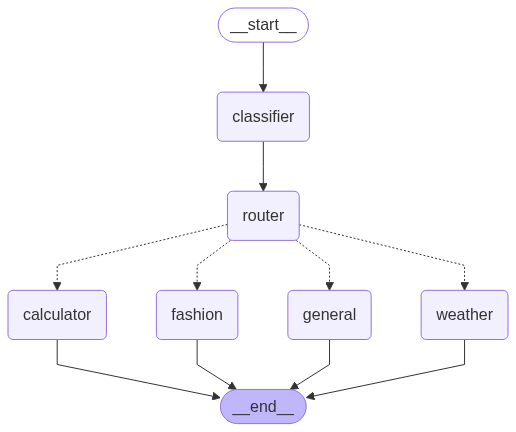

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print("Error during graph printing:", e)
    pass


Taking user input and processing graph invocation with the past message history kept in memory, until the user query says "exit"

In [18]:
def run_chatbot():
    state = {"messages": []}

    while(True):
        user_input = input("You: ")
        if user_input.lower() == "exit":
            print("Goodbye!")
            break
        
        state["messages"].append(HumanMessage(content=user_input))
        
        try:
            final_state = graph.invoke(state)
            
            if final_state.get("messages") and isinstance(final_state["messages"][-1], AIMessage):
                print(f"Assistant: {final_state['messages'][-1].content}")
            else:
                print("Assistant: No response generated or unexpected message format.")

        except Exception as e:
            print(f"Error during graph invocation: {e}")
            print(f"Current State before error: {state}")
            
run_chatbot()

You:  Hi, I am Aditya Garg


Assistant: Hi Aditya Garg! It's nice to meet you. How can I help you today?


You:  Can you evaluate 2*5+10/2-2^4/2


Assistant: 7



You:  Great! What is the weather in Guwahati right now?


Assistant: The weather in Guwahati is currently misty with a temperature of 26.95 degrees Celsius, atmospheric pressure of 1005 hPa, and humidity of 89%.



You:  Can you tell me about the current fashion trends in New York?


Assistant: Based on my search, here are some current fashion trends in New York:

*   **Elevated basics and tailored outerwear:** These were prominent during New York Fashion Week.
*   **Monochromatic Separates:** These were also a key part of the collections shown during Fashion Week.
*   **Y2K-inspired accessories:** Sunglasses and handbags are showing futuristic silhouettes and metallic materials.
*   **Loafers, peplum tops, and chunky sneakers:** These are being spotted on the streets of New York City.
*   **Flats and kitten heels:** Seen during New York Fashion Week.


You:  Oh Nice...do you remember my name?


Assistant: Yes, Aditya Garg. I remember your name.


You:  What expression did I give you to evaluate?


Assistant: You asked me to evaluate the expression `2*5+10/2-2^4/2`.


You:  Which city's weather did you fetch me?


Assistant: The weather in Guwahati: Temperature is 26.95 degrees Celsius, atmospheric pressure is 1005 hPa, humidity is 89%, and the description is mist.



You:  exit


Goodbye!
